<a href="https://colab.research.google.com/github/MuhammadHasbiAshshiddieqy/Lung_Classification_ConvNet/blob/master/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [90]:
import os
os.chdir('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/Spectogram')
os.getcwd()

'/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/Spectogram'

In [0]:
#You can do anything you want with the data after step 2. I will continue here to show my steps to create the simple CNN model.

# Import libraries
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

In [92]:
#Get csv file
df = pd.read_csv('/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/LabelEncoded.csv')
df.head()

,Id,File,StartRC,EndRC,Status,Class
0,0,101,0.036,1.907,1,0
1,1,101,1.907,4.521,0,0
2,2,101,4.521,7.193,1,0
3,3,101,7.193,9.750,0,0
4,4,101,9.750,12.407,1,0


In [93]:
def append_ext(id):
    return id+".png"

df_for_model = df[["Id","Class"]].astype("str")
df_for_model["Id"]=df_for_model["Id"].apply(append_ext)
df_for_model.head()

,Id,Class
0,0.png,0
1,1.png,0
2,2.png,0
3,3.png,0
4,4.png,0


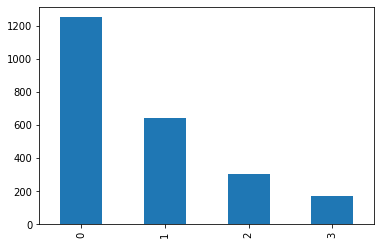

In [94]:
df_for_model['Class'].value_counts().plot.bar()

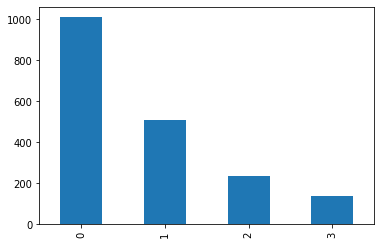

In [95]:
#Prepare Test and Train Data

train_df, validate_df = train_test_split(df_for_model, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['Class'].value_counts().plot.bar()

total_train = train_df.shape[0] #the number of images in the training df
total_validate = validate_df.shape[0]  #the number of images in the validate df
batch_size=18

In [96]:

IMAGE_WIDTH=304
IMAGE_HEIGHT=231
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 302, 229, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 302, 229, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 151, 114, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 149, 112, 64)      18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 149, 112, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 56, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 265216)           

In [97]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/Spectogram", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

Found 1895 validated image filenames belonging to 4 classes.


In [98]:
#Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/Spectogram", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size
)

Found 474 validated image filenames belonging to 4 classes.


Found 1 validated image filenames belonging to 1 classes.


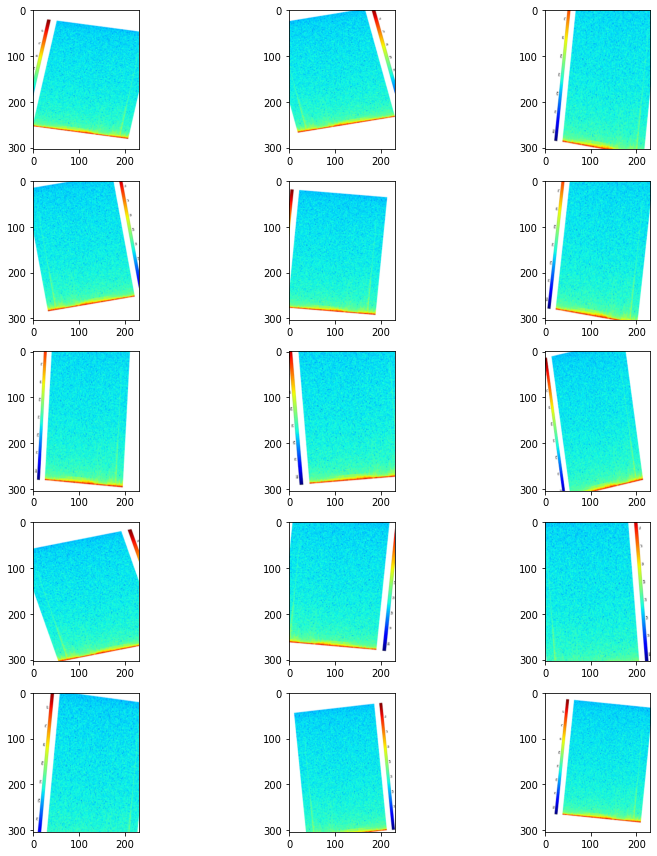

In [99]:

#See how the generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/gdrive/My Drive/Code TA/Data/Preprocessed Data/Spectogram", 
    x_col='Id',
    y_col='Class',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

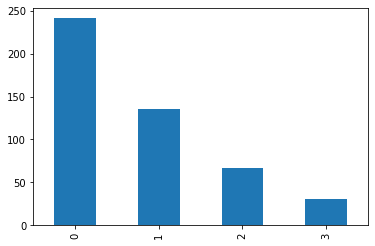

In [100]:
validate_df['Class'].value_counts().plot.bar()

In [0]:
#Early Stopping 

earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction

#We will reduce the learning rate when then accuracy is not increasing for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [104]:
#Fit Model

history = model.fit_generator(
    train_generator, 
    epochs=25,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/25
105/105 [==============================] - 410s 4s/step - loss: 0.6259 - accuracy: 0.7655 - val_loss: 6.2758 - val_accuracy: 0.2671
Epoch 2/25
105/105 [==============================] - 410s 4s/step - loss: 0.6253 - accuracy: 0.7668 - val_loss: 0.5911 - val_accuracy: 0.7533
Epoch 3/25
105/105 [==============================] - 411s 4s/step - loss: 0.5850 - accuracy: 0.7645 - val_loss: 0.5893 - val_accuracy: 0.7522
Epoch 4/25
105/105 [==============================] - 412s 4s/step - loss: 0.5708 - accuracy: 0.7666 - val_loss: 0.5601 - val_accuracy: 0.7533

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/25
105/105 [==============================] - 409s 4s/step - loss: 0.5604 - accuracy: 0.7684 - val_loss: 0.5463 - val_accuracy: 0.7621
Epoch 6/25
105/105 [==============================] - 416s 4s/step - loss: 0.5561 - accuracy: 0.7662 - val_loss: 0.5908 - val_accuracy: 0.7522
Epoch 7/25
105/105 [==============================] - 415s 4s

In [0]:
# Save Model
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

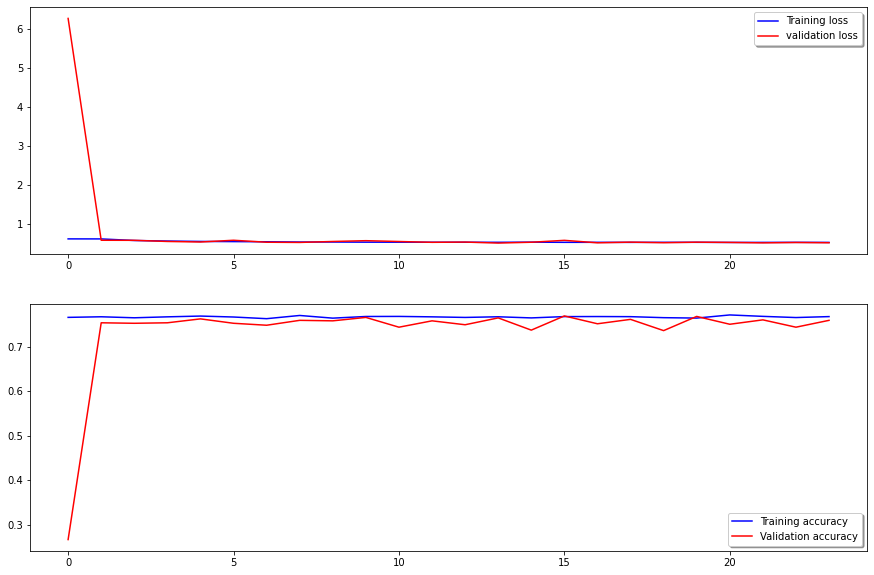

In [113]:
#Virtualize Training

fig, ax = plt.subplots(2,1)
plt.gcf().set_size_inches(15, 10)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)